# Case 1 - HWP

HWP Angle: 0
o_avg Mueller Matrix: [[ 0.48868945 -0.41875595  0.11073683 -0.04254534]
 [ 0.48868945 -0.41875595  0.11073683 -0.04254534]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.48849142  0.47464833  0.02989651 -0.06134271]
 [-0.48849142 -0.47464833 -0.02989651  0.06134271]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
HWP Angle: 10
o_avg Mueller Matrix: [[ 0.48879234 -0.38805636 -0.21180387 -0.15176227]
 [ 0.48879234 -0.38805636 -0.21180387 -0.15176227]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.48827711  0.39454549  0.37395385  0.05694367]
 [-0.48827711 -0.39454549 -0.37395385 -0.05694367]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
HWP Angle: 20
o_avg Mueller Matrix: [[ 0.48928093 -0.17679816 -0.

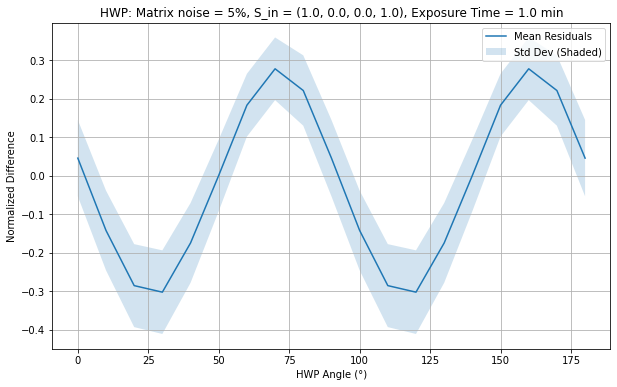

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm

# For collecting single differences
normalized_diffs_list = []

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    # {"name": "Mirfak", "ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    # {"name": "Polaris", "ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST
matrix_noise_type = "additive"

# Fixed integration time and sub-integration time
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1  # 0.5 seconds
num_samples = 100

# Injected polarization
Q_injected = 0.0  # Injected Stokes Q
U_injected = 0.0  # Injected Stokes U
V_injected = 1.0
noise_percentage = 0  # Intensity noise
include_V = False

# NOTE: For HWP
delta_HWP = 0.5
# HWP_angs = np.array([0, 22.5, 45, 67.5])
filename_tag = "HWP_regular_modulation"
HWP_angs = range(0, 181, 10)

# NOTE: For QWP
# delta_HWP = 0.25
# HWP_angs = [-42.54276834, 13.22282288, 44.37773779, 76.67675033]
# filename_tag = "QWP_Katsu_Measurement_Matrix_Inverse_Cond_Num_Minimization"
# HWP_angs = np.array([-45, 45, -135, 135])
# filename_tag = "QWP_measuring_V_only"

# NOTE: For 0.3661 waveplate
# delta_HWP = 0.3661
# HWP_angs = np.array([-51.69, 51.69, -15.12, 15.12])
# First Minimization Set
# HWP_angs = [4.27995253, 57.56520381, 31.06321892, -37.47077834]
# HWP_angs = [26.04379451, -9.86586612, 60.51771256, -41.96646101]
# filename_tag = "Third_wp"


# Matrix noise range
matrix_noise_range = np.arange(5, 6)  # From 1% to 5%
num_trials = 50  # Number of trials per noise level

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over matrix noise levels
    for matrix_noise in matrix_noise_range:
        residuals = []

        # Perform multiple trials for each noise level
        for trial in range(num_trials):
            normalized_diff = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                V=V_injected,
                delta_HWP=delta_HWP,
                HWP_angs = HWP_angs,
                noise_percentage=noise_percentage,
                include_V=include_V,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps = num_samples,
                matrix_noise_type = matrix_noise_type,
                return_type = "normalized_diff"
            )
            normalized_diffs_list.append(normalized_diff)

        # Compute mean and standard deviation of residuals for this noise level
        normalized_diffs_list = np.array(normalized_diffs_list)
        normalized_diffs_medians = np.median(normalized_diffs_list, axis = 0)
        normalized_diffs_stds = np.std(normalized_diffs_list, axis = 0)

        # Save the residuals as a .npy file
        filename = f"{target['name']}_QWP_Q_{Q_injected}_U_{U_injected}_V_{V_injected}_residuals_matrix_noise_{matrix_noise}_tint_{t_int}_sub_tint_{sub_tint}_readout_noise_{noise_percentage}_{matrix_noise_type}_{filename_tag}.npy"
        np.save(filename, np.array(normalized_diffs_list))
        print(f"Saved residuals to {filename}")

    # Plot the NOrmalized difference 
    plt.figure(figsize=(10, 6))

    plt.plot(HWP_angs, normalized_diffs_medians, label=f"Mean Residuals")
    plt.fill_between(HWP_angs, normalized_diffs_medians - normalized_diffs_stds, normalized_diffs_medians + normalized_diffs_stds, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel("HWP Angle (°)")
    plt.ylabel("Normalized Difference")
    plt.title(
        f"HWP: Matrix noise = {matrix_noise}%, S_in = (1.0, {Q_injected}, {U_injected}, {V_injected}), Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()


# CASE 2: QWP sampling all Stokes parameters

HWP Angle: 0
o_avg Mueller Matrix: [[ 0.4890548   0.05970693  0.17277484 -0.50793921]
 [ 0.4890548   0.05970693  0.17277484 -0.50793921]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.48761628  0.02935797 -0.10397822  0.45035874]
 [-0.48761628 -0.02935797  0.10397822 -0.45035874]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
HWP Angle: 10
o_avg Mueller Matrix: [[ 0.48909151  0.09448155  0.02598106 -0.53516593]
 [ 0.48909151  0.09448155  0.02598106 -0.53516593]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.48750818 -0.03967681  0.05393402  0.44348659]
 [-0.48750818  0.03967681 -0.05393402 -0.44348659]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
HWP Angle: 20
o_avg Mueller Matrix: [[ 0.4893233   0.21439613 -0.

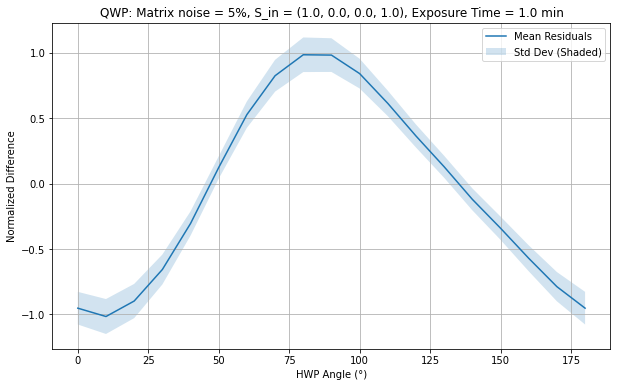

In [2]:
# For collecting single differences
normalized_diffs_list = []

# NOTE: For QWP
delta_HWP = 0.25
filename_tag = "QWP"

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over matrix noise levels
    for matrix_noise in matrix_noise_range:
        residuals = []

        # Perform multiple trials for each noise level
        for trial in range(num_trials):
            normalized_diff = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                V=V_injected,
                delta_HWP=delta_HWP,
                HWP_angs = HWP_angs,
                noise_percentage=noise_percentage,
                include_V=include_V,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps = num_samples,
                matrix_noise_type = matrix_noise_type,
                return_type = "normalized_diff"
            )
            normalized_diffs_list.append(normalized_diff)

        # Compute mean and standard deviation of residuals for this noise level
        normalized_diffs_list = np.array(normalized_diffs_list)
        normalized_diffs_medians = np.median(normalized_diffs_list, axis = 0)
        normalized_diffs_stds = np.std(normalized_diffs_list, axis = 0)

        # Save the residuals as a .npy file
        filename = f"{target['name']}_QWP_Q_{Q_injected}_U_{U_injected}_V_{V_injected}_residuals_matrix_noise_{matrix_noise}_tint_{t_int}_sub_tint_{sub_tint}_readout_noise_{noise_percentage}_{matrix_noise_type}_{filename_tag}.npy"
        np.save(filename, np.array(normalized_diffs_list))
        print(f"Saved residuals to {filename}")

    # Plot the NOrmalized difference 
    plt.figure(figsize=(10, 6))

    plt.plot(HWP_angs, normalized_diffs_medians, label=f"Mean Residuals")
    plt.fill_between(HWP_angs, normalized_diffs_medians - normalized_diffs_stds, normalized_diffs_medians + normalized_diffs_stds, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel("HWP Angle (°)")
    plt.ylabel("Normalized Difference")
    plt.title(
        f"QWP: Matrix noise = {matrix_noise}%, S_in = (1.0, {Q_injected}, {U_injected}, {V_injected}), Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()


# CASE 3: 1/3 Waveplate

HWP Angle: 0
o_avg Mueller Matrix: [[ 0.48898891 -0.29241169  0.21049432 -0.33754742]
 [ 0.48898891 -0.29241169  0.21049432 -0.33754742]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.48728249  0.32679363 -0.18634674  0.36205544]
 [-0.48728249 -0.32679363  0.18634674 -0.36205544]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
HWP Angle: 10
o_avg Mueller Matrix: [[ 0.48905835 -0.25013238 -0.04465402 -0.37876108]
 [ 0.48905835 -0.25013238 -0.04465402 -0.37876108]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
e_avg Mueller Matrix: [[ 0.48724096  0.29834199  0.07399469  0.41085567]
 [-0.48724096 -0.29834199 -0.07399469 -0.41085567]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
HWP Angle: 20
o_avg Mueller Matrix: [[ 0.48944648 -0.05372466 -0.

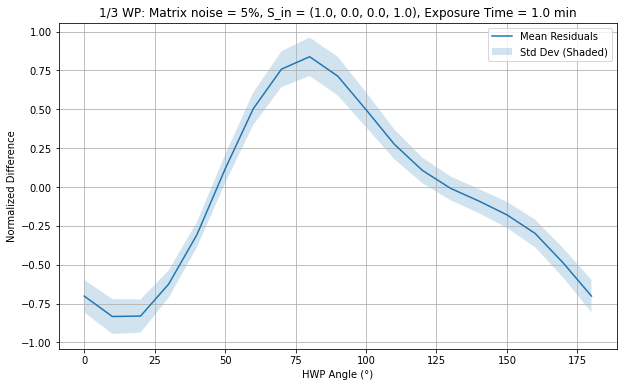

In [3]:
# For collecting single differences
normalized_diffs_list = []

# NOTE: For QWP
delta_HWP = 0.3661
filename_tag = "Third_WP"

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over matrix noise levels
    for matrix_noise in matrix_noise_range:
        residuals = []

        # Perform multiple trials for each noise level
        for trial in range(num_trials):
            normalized_diff = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                V=V_injected,
                delta_HWP=delta_HWP,
                HWP_angs = HWP_angs,
                noise_percentage=noise_percentage,
                include_V=include_V,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps = num_samples,
                matrix_noise_type = matrix_noise_type,
                return_type = "normalized_diff"
            )
            normalized_diffs_list.append(normalized_diff)

        # Compute mean and standard deviation of residuals for this noise level
        normalized_diffs_list = np.array(normalized_diffs_list)
        normalized_diffs_medians = np.median(normalized_diffs_list, axis = 0)
        normalized_diffs_stds = np.std(normalized_diffs_list, axis = 0)

        # Save the residuals as a .npy file
        filename = f"{target['name']}_QWP_Q_{Q_injected}_U_{U_injected}_V_{V_injected}_residuals_matrix_noise_{matrix_noise}_tint_{t_int}_sub_tint_{sub_tint}_readout_noise_{noise_percentage}_{matrix_noise_type}_{filename_tag}.npy"
        np.save(filename, np.array(normalized_diffs_list))
        print(f"Saved residuals to {filename}")

    # Plot the NOrmalized difference 
    plt.figure(figsize=(10, 6))

    plt.plot(HWP_angs, normalized_diffs_medians, label=f"Mean Residuals")
    plt.fill_between(HWP_angs, normalized_diffs_medians - normalized_diffs_stds, normalized_diffs_medians + normalized_diffs_stds, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel("HWP Angle (°)")
    plt.ylabel("Normalized Difference")
    plt.title(
        f"1/3 WP: Matrix noise = {matrix_noise}%, S_in = (1.0, {Q_injected}, {U_injected}, {V_injected}), Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()
